In [1]:
import qubic.toolchain as tc
import qubic.rpc_client as rc
import qubitconfig.qchip as qc
from distproc.hwconfig import FPGAConfig, load_channel_configs
import numpy as np
import matplotlib.pyplot as plt

# Play a simple pulse

## Load configuration information

1) define FPGA config; this has timing information for the scheduler. For now it is fine to use the following hardcoded config TODO for tutorial: put these parameters somewhere in the repo so it's not hardcoded for the demo

In [2]:
fpga_config = FPGAConfig(**{'fpga_clk_period': 2.e-9, 
                            'alu_instr_clks': 5, 
                            'jump_cond_clks': 5, 
                            'jump_fproc_clks': 5, 
                            'pulse_regwrite_clks': 3})

2. load channel configs, which assign named output channels to physical DAC outputs (or readout downconversion channels) and configure signal generator parameters. (see [Understanding Channel Configuration](https://gitlab.com/LBL-QubiC/software/-/wikis/Understanding-Channel-Configuration) for details)


In [3]:
channel_configs = load_channel_configs('channel_config.json')

example channel config for named output 'Q0.qdrv' (qubit drive channel for physical qubit 'Q0'): 

`ChannelConfig(core_ind=7, elem_ind=0, elem_params={'samples_per_clk': 16, 'interp_ratio': 1}, _env_mem_name='qdrvenv{core_ind}', _freq_mem_name='qdrvfreq{core_ind}', _acc_mem_name='accbuf{core_ind}')`

The physical output channel is given by `core_ind` and `elem_ind`, while signal generator params are given by `elem_params`.


## Define the pulse sequence

QubiC circuits (or "programs") are defined as lists of dictionary. Each dictionary is a pulse command, program statement, or timing construct

In [5]:
circuit = [
    #play a single pulse on the Q0 drive channel
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.334704954261188, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'}, 
    
]

## Compile and Assemble

Compile the program. Since we don't have any references to gates, we can pass None to the qchip argument. The output of the compile stage is a distributed processor assembly program, which consists of initialization/termination statements, as well as a list of scheduled pulses for each core. Our program only uses one processor core, scoped to channels `('Q0.qdrv', 'Q0.rdrv', 'Q0.rdlo')`.

In [6]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None)
compiled_prog.program

{('Q0.qdrv', 'Q0.rdrv', 'Q0.rdlo'): [{'op': 'phase_reset'},
  {'op': 'pulse',
   'freq': 4944383311,
   'phase': 0,
   'amp': 0.334704954261188,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2.4e-08}},
   'start_time': 5,
   'dest': 'Q0.qdrv'},
  {'op': 'done_stb'}]}

Run the assembler to convert the above program into machine code that we can load onto the FPGA or gateware simulation:

In [7]:
raw_asm = tc.run_assemble_stage(compiled_prog, channel_configs)

## Connect to Server and Run Circuit

Now that we've defined our circuit and compiled it to machine code, we can submit it to the ZCU216 and run it.

Instantiate the runner client:

In [14]:
runner = rc.CircuitRunnerClient(ip='192.168.1.247', port=9095)

Submit the circuit to the server, and collect 5000 shots: 

In [24]:
s11 = runner.run_circuit_batch([raw_asm], 5000, delay_per_shot=0)

A dictionary of downconverted + integrated complex (IQ) values is returned for each loaded channel. In this case, we only performed drive + readout on Q2, so only channel '1' (corresponding to the core_ind of Q2.rdlo) was returned.

In [25]:
s11.keys()

dict_keys(['1'])

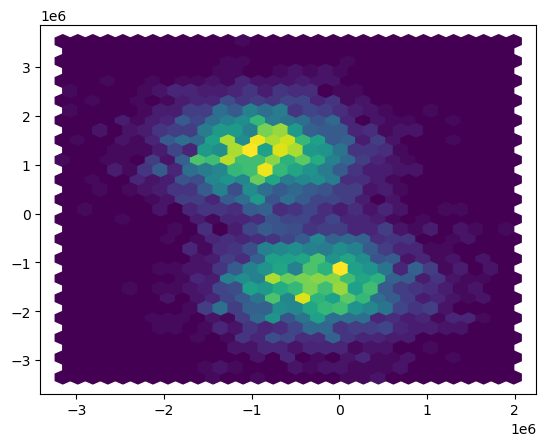

In [27]:
plt.hexbin(s11['1'].real, s11['1'].imag, gridsize=30)